In [1]:
import numpy as np
import cv2
import scipy.misc
from skimage import color
import torch
from IPython import embed
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt

# import model_rec as model
import model_rec_noupreshape as model

%matplotlib inline

## Constants and helper functions

In [2]:
# ***** CONSTANTS *****
l_norm = 100.
l_cent = 50.
ab_norm = 110.
mask_cent = 0.
# mask_cent = .5
mask_mult = 1.
use_gpu = False
H_proc, W_proc = (256,256) # resolution to process, needs to be multiple of 8

# color bins for color classification and output recommendations
A = 23 # the ab colormap is divided up into 23x23 color bins
AB = A**2 # there are 23*23=529 color bins in total
ab_step = 10 # spacing between discretized color bins
ab_edge = ab_norm + ab_step/2
a_range = np.arange(-ab_norm, ab_norm+ab_step, step=ab_step)
bbs, aas = np.meshgrid(a_range, a_range)
aas = aas.flatten()
bbs = bbs.flatten()
abs = np.concatenate((aas[:,None],bbs[:,None]),axis=1) # 529x2, list of discretized bin centers
abs_norm = abs/ab_norm # 529x2, bin centers normalized from [-1, +1]
MAX_ENTROPY = np.log(AB)

K = 7 # number of recommendations from kmeans network

# ***** HELPER FUNCTIONS *****
def add_color_patch(in_ab,in_mask,ab=[0,0],hw=[128,128],P=5):
	# add a color patch
	in_ab[hw[0]:hw[0]+P,hw[1]:hw[1]+P,0] = ab[0]
	in_ab[hw[0]:hw[0]+P,hw[1]:hw[1]+P,1] = ab[1]
	in_mask[hw[0]:hw[0]+P,hw[1]:hw[1]+P,:] = 1.
	return (in_ab,in_mask)

def np2tens(in_np,use_gpu=True):
	# numpy HxWxC ==> Torch tensor 1xCxHxW
	out_tens = torch.Tensor(in_np.transpose((2,0,1)))[None,:,:,:]
	if(use_gpu):
		out_tens = out_tens.cuda()
	else:
		out_tens = out_tens.cpu()
	return out_tens

def tens2np(in_tens,use_gpu=True):
	# Torch tensor 1xCxHxW ==> numpy HxWxC
	if(use_gpu):
		return in_tens.cpu().numpy().transpose((2,3,1,0))[:,:,:,0]
	else:
		return in_tens.numpy().transpose((2,3,1,0))[:,:,:,0]

def ind2sub(ind, H=64, W=64):
    return (ind/H, ind - ind/H*H)

# Colorizer and color recommendation networks

In [3]:
# ***** LOAD COLORIZER MODEL *****
colorizer = model.SIGGRAPHGenerator()
# colorizer.load_state_dict(torch.load('./models/net_G_19_03_04_trained1ep.pth'))
# colorizer.load_state_dict(torch.load('./models/caffemodel_mask01.pth'))
colorizer.load_state_dict(torch.load('./models/caffemodel_mask01_rec.pth'))
colorizer.cuda() if(use_gpu) else colorizer.cpu()
colorizer.eval()

# ***** COLOR RECOMMENDATION NETWORK *****
# network converts probability distribution ==> K discrete recommendations
recommender = model.KMeansGenerator(AB, K)
recommender.load_state_dict(torch.load('./models/net_K_03_07.pth'))
recommender.cuda() if use_gpu else recommender.cpu()
recommender.eval();

## Load image and preprocess

In [4]:
# ***** LOAD IMAGE, PREPARE DATA *****
img_orig = cv2.imread('./imgs/migrant_mother.jpg')[:,:,::-1]
(H_orig,W_orig) = img_orig.shape[:2]
print('[%ix%i] Original resolution'%(H_orig,W_orig))
print('[%ix%i] Processed resolution'%(H_proc,W_proc))

# take L channel at fullres
img_orig_lab = color.rgb2lab(img_orig)
img_orig_l = img_orig_lab[:,:,[0]]

# resize to processing size, take L channel for input
img_rs = cv2.resize(img_orig, (W_proc, H_proc), interpolation=cv2.INTER_CUBIC)
img_rs_lab = color.rgb2lab(img_rs)
img_rs_l_norm = (img_rs_lab[:,:,[0]]-l_cent)/l_norm # normalized

[1583x1242] Original resolution
[256x256] Processed resolution


## Define function for running the model

In [5]:
def run_model(in_ab, in_mask, verbose=False):
    # normalize & center input ab, input mask
    in_ab_norm = in_ab/ab_norm
    in_mask_norm = (in_mask - mask_cent)*mask_mult

    if(verbose):
        print('L bounds: [%.3f,%.3f]'%(np.min(img_rs_l_norm).item(),np.max(img_rs_l_norm).item()))
        print('ab bounds: [%.3f,%.3f]'%(np.min(in_ab_norm).item(),np.max(in_ab_norm).item()))
        print('mask bounds: [%.3f,%.3f]'%(np.min(in_mask_norm).item(),np.max(in_mask_norm).item()))
    out_class, out_reg = colorizer.forward(np2tens(img_rs_l_norm,use_gpu=use_gpu), np2tens(in_ab_norm,use_gpu=use_gpu), np2tens(in_mask_norm,use_gpu=use_gpu))
    out_class = out_class.data # 1 x AB x H_proc x W_proc, probability distribution at every spatial location (h,w) of possible colors
    out_reg = out_reg.data # 1 x 2 x H_proc x W_proc

    out_ab_norm = tens2np(out_reg)
    out_ab = out_ab_norm*ab_norm # un-normalize

    # ***** CONCATENATE WITH INPUT *****
    # resize output to original resolution
    out_orig_ab = zoom(out_ab, (1.*H_orig/H_proc, 1.*W_orig/W_proc, 1) )

    # concatenate with L channel, convert to RGB, save
    out_orig_lab = np.concatenate((img_orig_l,out_orig_ab),axis=2)
    out_orig_rgb = np.uint8(np.clip(color.lab2rgb(out_orig_lab),0,1)*255)
    # cv2.imwrite('./imgs/migrant_mother/output_fullres.png',out_orig_rgb[:,:,::-1])

    return (out_orig_rgb, out_class, out_reg)

# ***** COMPUTE UNCERTAINTY *****
def compute_entropy(out_class):
    out_entropy = -torch.sum(out_class*torch.log(out_class),dim=1,keepdim=True)
    out_entropy = out_entropy[0,0,:,:].data.numpy()

    # grab least certain point
    max_ind = np.argmax(out_entropy)
    (max_h, max_w) = ind2sub(max_ind, H=out_entropy.shape[0], W=out_entropy.shape[1])

    return(out_entropy, (max_h,max_w))

def get_recommended_colors(out_class, (h,w)):
    # capture the probability distribution at a single point
    out_class_point = out_class[0,:,h,w] # 529, probability distribution over discretized space
    in_point = img_rs_lab[h,w,0] # grayscale value

    # use recommender network to get 7 discrete recommendations
    reccs_ab = ab_norm*recommender(out_class_point[None,:,None,None]).reshape(K,2).data.cpu().numpy() # 7x2 list of colors in ab space

    # convert recommended colors to RGB and display
    reccs_lab = np.concatenate((in_point+np.zeros((K,1)),reccs_ab),axis=1)
    reccs_rgb = color.lab2rgb(reccs_lab[None,:,:])

    # recommender produces unordered points, compute an ordering based on probability distribution
    dists = np.sum((reccs_ab[None,:,:] - abs[:,None,:])**2,axis=2) # for each of the 529 bins, compute distance to each of the recommended colors
    inds = np.argmin(dists,axis=1) # for each of the 529 bins, figure out which recommended color is the closest
    reccs_probs = np.array([np.sum(out_class_point.data.cpu().numpy()[inds==kk]) for kk in range(K)]) # probability of each of the recommended colors, should sum to 1
    reccs_sorted_inds = np.argsort(reccs_probs)[::-1]
    
    reccs_ab = reccs_ab[reccs_sorted_inds,:]
    reccs_probs = reccs_probs[reccs_sorted_inds]
    reccs_rgb = reccs_rgb[:,reccs_sorted_inds,:]
    
    return (out_class_point.data.cpu().numpy(), reccs_rgb, reccs_ab, reccs_probs)

# ***** REHEATING DISTRIBUTION *****
def softmax(logits):
    logits = logits-np.max(logits)
    return np.exp(logits)/np.sum(np.exp(logits))

def reheat_distribution(dist, T=.5):
    return softmax(np.log(dist)/T)

L bounds: [-0.500,0.500]
ab bounds: [0.000,0.000]
mask bounds: [0.000,0.000]
[0] Adding ab=(0.0,-20.0) to hw=(124,16)


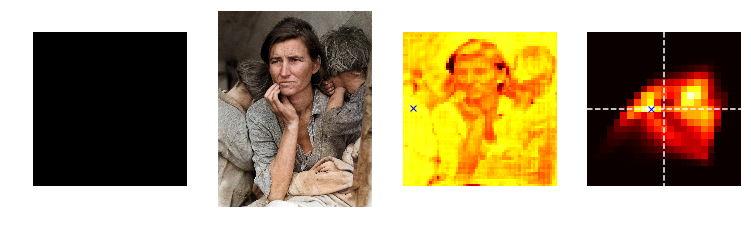

In [8]:
# ***** INITIALIZE COLOR INPUT POINTS *****
in_ab = np.zeros((H_proc, W_proc, 2)) # initialize blank ab input, mask
in_mask = np.zeros((H_proc, W_proc, 1))

sample_color = 'max' # choose from 'rand','max','mean'
T = 0.125 # temperature if choosing 'rand'
    # T-->0 is equivalent to 'max'
    # T < 1 makes things closer to 'max'
    # T = 1 draws from predicted distribution
    # T > 1 makes distribution more random
    # T-->inf is equivalent to choosing a random color

pts = []
    
NUM_POINTS = 1
for nn in range(NUM_POINTS):
    # Run model
    (out_orig_rgb, out_class, out_reg) = run_model(in_ab, in_mask, verbose=True)
    H_DS_FACTOR = out_reg.shape[2]/out_class.shape[2]
    W_DS_FACTOR = out_reg.shape[3]/out_class.shape[3]
    
    # Compute entropy and most uncertain point
    out_entropy,(max_h,max_w) = compute_entropy(out_class)
    pts.append([max_h, max_w])
    
    # Get probability distribution for most uncertain point
    out_class_point = out_class[0,:,max_h,max_w].data.cpu().numpy()

    # Plot results
    plt.figure(figsize=(16,4))
    plt.subplot(1,5,1)
    plt.imshow(in_mask*color.lab2rgb(np.concatenate((50+np.zeros((H_proc,W_proc,1)),in_ab),axis=2)))
    plt.axis('off')

    plt.subplot(1,5,2)
    plt.imshow(out_orig_rgb)
    plt.axis('off')

    plt.subplot(1,5,3)
    plt.imshow(out_entropy, clim=(0,MAX_ENTROPY), cmap='hot')
    plt.plot(max_w, max_h, 'bx')
    plt.axis('off')

    plt.subplot(1,5,4)
    plt.imshow(out_class_point.reshape(A,A), cmap='hot', extent=[-ab_edge,ab_edge,ab_edge,-ab_edge])
    plt.plot([-ab_edge,ab_edge],[0,0],'w--')
    plt.plot([0,0],[-ab_edge,ab_edge],'w--')
    plt.xlabel('b'); plt.ylabel('a');
    plt.axis('off');        

    # Determine next color to add
    if(sample_color=='rand'): # Sample randomly from probability distribution and add
        reheat_class_point = reheat_distribution(out_class_point,T=T)
        rand_ind = np.random.choice(range(AB),size=1,p=reheat_class_point/np.sum(reheat_class_point))[0]
        ab_next = abs[rand_ind,:]
    elif(sample_color=='max'): # Simply grab the most likely color
        max_ind = np.argmax(out_class_point)
        ab_next = abs[max_ind,:]
    elif(sample_color=='mean'): # Grab mean of distribution
        ab_next = np.sum(abs*out_class_point[:,None],axis=0)
        
    # Add next color
    print('[%i] Adding ab=(%.1f,%.1f) to hw=(%i,%i)'%(nn,ab_next[0],ab_next[1],max_h*H_DS_FACTOR,max_w*W_DS_FACTOR))
    (in_ab, in_mask) = add_color_patch(in_ab, in_mask, ab=ab_next, hw=[max_h*H_DS_FACTOR,max_w*W_DS_FACTOR], P=5)

    # Plot added color
    plt.plot(ab_next[1],ab_next[0],'bx')

In [9]:
# ***** INITIALIZE COLOR INPUT POINTS *****
in_ab = np.zeros((H_proc, W_proc, 2)) # initialize blank ab input, mask
in_mask = np.zeros((H_proc, W_proc, 1))

sample_color = 'rand' # choose from 'rand','max','mean'
T = 0.25 # temperature if choosing 'rand'
    # T-->0 is equivalent to 'max'
    # T < 1 makes things closer to 'max'
    # T = 1 draws from predicted distribution
    # T > 1 makes distribution more random
    # T-->inf is equivalent to choosing a random color

NUM_POINTS = 4

# Run model
(out_orig_rgb, out_class, out_reg) = run_model(in_ab, in_mask, verbose=True)
H_DS_FACTOR = out_reg.shape[2]/out_class.shape[2]
W_DS_FACTOR = out_reg.shape[3]/out_class.shape[3]

# Compute entropy and most uncertain point
out_entropy, (max_h,max_w) = compute_entropy(out_class)


L bounds: [-0.500,0.500]
ab bounds: [0.000,0.000]
mask bounds: [0.000,0.000]


In [24]:
highest_pts = np.array(ind2sub(np.argsort(out_entropy.flatten())[::-1][:7]))

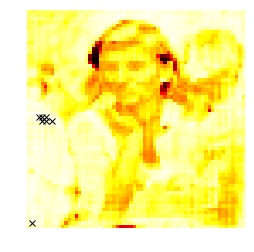

In [54]:
plt.imshow(out_entropy, cmap='hot')
plt.plot(highest_pts[1,:], highest_pts[0,:], 'kx')
plt.axis('off');

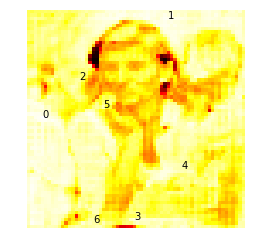

In [52]:
pts = np.array(pts)
plt.imshow(out_entropy, cmap='hot')
for nn in range(7):
    plt.text(pts[nn,1], pts[nn,0], '%i'%nn)
plt.axis('off');